# Tackling Class Imbalanced Dataset Using Oversampling: Credit Fraud

### Introduction 

Financial institutions face significant monetary and reputational losses due to credit card fraud. This project aims to develop a machine learning model using Python to detect fraudulent transactions. However, real-world credit card fraud data is scarce due to privacy concerns. Additionally, most transactions are legitimate, resulting in a class-imbalanced dataset where fraudulent transactions (Class 1) are significantly outnumbered by valid transactions (Class 0). This imbalance can hinder model performance. To address this challenge, this project will explore oversampling which creates copies of the rows with the minority class label until it is balanced. The models that will be used are logistical regression and decision tree.

We will utilize a synthetic dataset from Kaggle based off this one (https://www.kaggle.com/datasets/ealaxi/paysim1) with less rows to train and test our models.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

import warnings
warnings.filterwarnings('ignore')
transactions = pd.read_csv('transactions.csv')

In [2]:
print(transactions.shape)

(199999, 10)


### Meta Data Analysis

In [3]:
print(transactions.head(1))
print("\n")
print(transactions.isnull().sum()) #Checking for any nulls

   step      type     amount    nameOrig  oldbalanceOrg  newbalanceOrig  \
0     8  CASH_OUT  158007.12  C424875646            0.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C1298177219       474016.32      1618631.97        0  


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


Above is an example of a row in the dataset. The columns are also listed. However a note from the author of this dataset provides a warning about which columns to use. 

*" NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.*

#### Column Descriptions:

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. "

- *isFlaggedFraud* - This column is omitted from the dataset in this project.

### Model Features and Label Definition

Our model's feature will be amount, isPayment, and isMovement. These last 2 are not columns originally in the data set. 

- isPayment will be 1 if type is Payment or Debit, otherwise it will be 0. 
- isMovement will be 1 if type is Cash-Out or Transfer, and a 0 if not.

The label will be isFraud which is 0 for valid transaction and 1 for fradulent transaction

### Data Pre-Processing

In [4]:
# Create isPayment field
transactions['isPayment'] = transactions['type'].apply(lambda x: 1 if x in ['PAYMENT', 'DEBIT'] else 0)
# Create isMovement field
transactions['isMovement'] =  transactions['type'].apply(lambda x: 1 if x in ['CASH_OUT', 'TRANSFER'] else 0)
# Create features and label variables
features = ['amount','isPayment','isMovement']
label = ['isFraud']

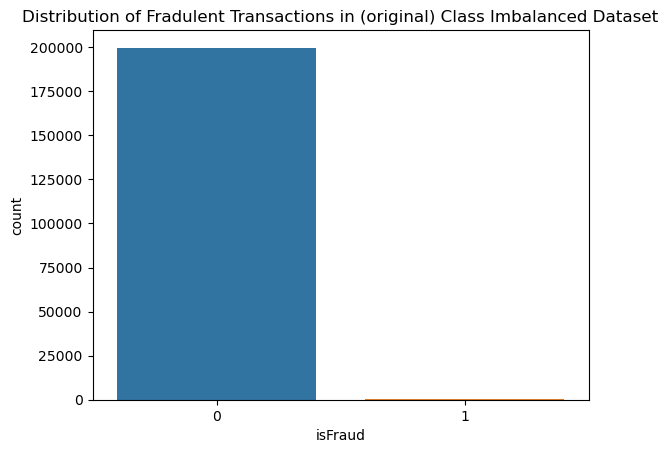

In [5]:
sns.countplot(x=transactions['isFraud'], data=transactions,hue='isFraud',legend=None)
plt.title("Distribution of Fradulent Transactions in (original) Class Imbalanced Dataset")
plt.show()

The above plots show the distribution of transactions that are fraudulent. The orange bar can barely be seen which illustrates the class imbalance of this data set. Oversampling will help balance this dataset.

In [6]:
# Create Over Sampler
ros = RandomOverSampler(random_state=42) 
#Create Oversampled X and Y set
X_os, y_os = ros.fit_resample(transactions[features],transactions[label])

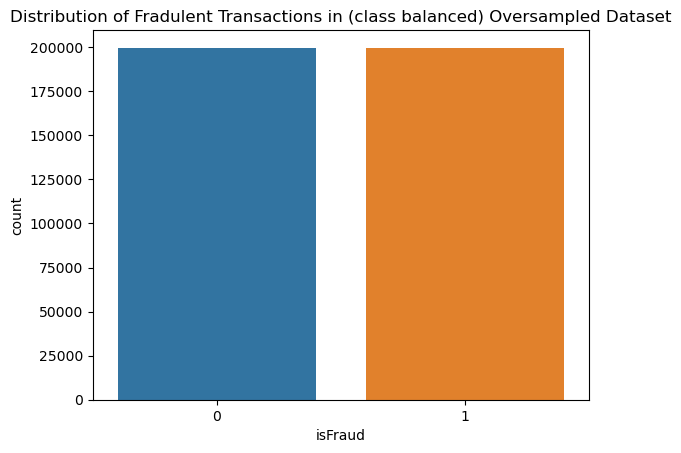

In [7]:
sns.countplot(x='isFraud', data=y_os,hue='isFraud',legend=None)
plt.title("Distribution of Fradulent Transactions in (class balanced) Oversampled Dataset")
plt.show()

Above we can see the result of oversampling on the count of fradulent transactions.

The following code blocks split our datasets into training and test sets and then normalizes and reshapes it for our models. The functions defined will also help later when visualizing our models performance.

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(transactions[features],transactions[label],test_size = 0.3)
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os,test_size = 0.3)

# Normalize the features variables
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
y_train=y_train.squeeze()
y_test=y_test.squeeze()

X_train_os = ss.fit_transform(X_train_os)
y_train_os=y_train_os.squeeze()

In [9]:
def cm_heatmap_comparison(ci,os,cart_labels):
    fig, (ax1, ax2) = plt.subplots(1,2)

    sns.heatmap(ci, annot=True, ax = ax1,fmt="d",linecolor="green",linewidths=1, cbar=False);
    sns.heatmap(os, annot=True, ax = ax2,fmt="d",linecolor="green",linewidths=1, cbar=False);
    # labels, title and ticks
    ax1.set_title('Class Imbalanced');
    ax1.set_xlabel('Predicted labels');
    ax1.set_ylabel('True labels'); 
    ax1.yaxis.set_tick_params(rotation=360)
    ax1.xaxis.set_ticklabels(cart_labels); 
    ax1.yaxis.set_ticklabels(cart_labels);
    
    ax2.set_title('Oversampled');
    ax2.set_xlabel('Predicted labels');
    ax2.set_ylabel('True labels'); 
    ax2.yaxis.set_tick_params(rotation=360)
    ax2.xaxis.set_ticklabels(cart_labels); 
    ax2.yaxis.set_ticklabels(cart_labels);
    plt.subplots_adjust( left=0.1,right=1.5, top=0.9, bottom=0.15, wspace=0.4)  # Adjust spacing parameters

    plt.show()

In [10]:
def plot_classification_report_compare(classification_report_dict,classification_report_dict_b):
   
    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12, 6)) 
    # Extract the precision and recall scores for class 0 and 1
    precision_0 = classification_report_dict['0']['precision']
    precision_1 = classification_report_dict['1']['precision']
    recall_0 = classification_report_dict['0']['recall']
    recall_1 = classification_report_dict['1']['recall']
    
    # Create a DataFrame with the scores
    data = {'Precision': [precision_0, precision_1], 'Recall': [recall_0, recall_1]}
    df = pd.DataFrame(data, index=['Class 0', 'Class 1'])

    # Repeat but now with classification_report_dict_b
    precision_0_b = classification_report_dict_b['0']['precision']
    precision_1_b = classification_report_dict_b['1']['precision']
    recall_0_b = classification_report_dict_b['0']['recall']
    recall_1_b = classification_report_dict_b['1']['recall']    
    data_b = {'Precision': [precision_0_b, precision_1_b], 'Recall': [recall_0_b, recall_1_b]}
    df_b = pd.DataFrame(data_b, index=['Class 0', 'Class 1'])
    
    # Create the bar chart
    df.plot(kind='bar',ax=ax1)
    ax1.set_title('Class Imbalanced')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel('Score')
    df_b.plot(kind='bar',ax=ax2)
    ax2.set_title('Oversampled')
    ax2.tick_params(axis='x', rotation=45)
    plt.show()

### Model Evaluation Metrics:

We will be using a confusion matrix to help us visualize how well our models are performing. The following image shows what each quadrant represents. The quadrant most important to us is the bottom left (FN) which represents false negatives. This is the most important because if our model flags a transaction as valid (class 0) but is actually fradulent (class 1) then that can lead to monetary and reputational loss. 

We can also measure how well our model is doing with numerical formulas like recall and precision. Recall is important to us since we want minimal instances of false negatives. Ideally our model will have a high recall score for class 1.

![Image of Confusion Matrix](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/8_confusion-matrix-python.jpg)


![Image of Precision and Recall Formula](https://miro.medium.com/v2/resize:fit:640/format:webp/1*7J08ekAwupLBegeUI8muHA.png)


## Logistical Regression

In [11]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_predictions = lr.predict(X_test)

lr_os = LogisticRegression()
lr_os.fit(X_train_os,y_train_os)
lr_predictions_os = lr_os.predict(X_test)

lr_hm = confusion_matrix(y_test,lr_predictions)
lr_hm_os = confusion_matrix(y_test,lr_predictions_os)

lr_cr = classification_report(y_test, lr_predictions,output_dict=True)
lr_os_cr = classification_report(y_test, lr_predictions_os,output_dict=True)

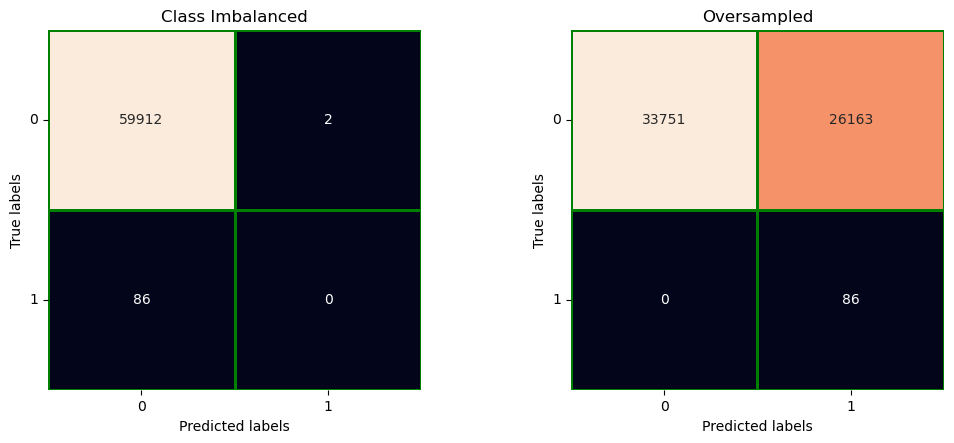

In [12]:
cm_heatmap_comparison(lr_hm,lr_hm_os,lr.classes_)

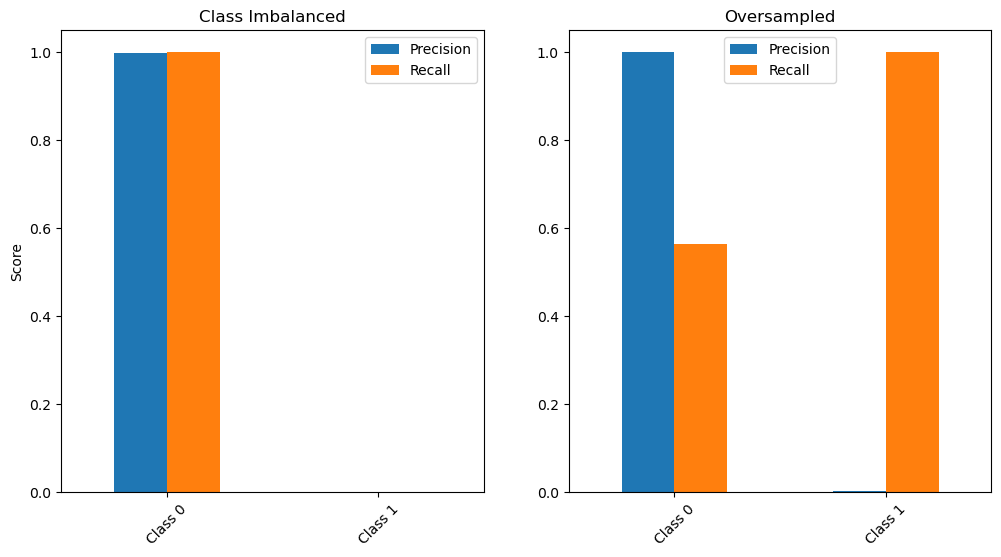

In [13]:
plot_classification_report_compare(lr_cr,lr_os_cr)

From the above confusion matrix we can see our class imbalanced dataset trained model has a lot of false negatives (bottom left quadrant). It performs well in terms of correctly identifying class 0 (valid) transactions but fails at identifying any fraudulent transactions as shown by the low recall score for class 1. 

When we train and test the model on the oversampled dataset, it correctly identifies all fradulent transactions which results in a high recall score for class 1. However it should be noted the precision score for class 1 is very low which means the the amount of false positives were high. In essence it was too eager and labeled valid transactions as fradulent which in the real world would lead to many disgruntled customers. 

## Decision Tree Classifier on Class Imbalance Dataset

In [14]:
cart_model = DecisionTreeClassifier(max_depth=5)
cart_model.fit(X_train, y_train) 
cart_predictions = cart_model.predict(X_test) 

cart_model_os = DecisionTreeClassifier(max_depth=5)
cart_model_os.fit(X_train_os, y_train_os) 
cart_predictions_os = cart_model_os.predict(X_test) 

cart_hm = confusion_matrix(y_test,cart_predictions)
cart_hm_os = confusion_matrix(y_test,cart_predictions_os)

cart_cr = classification_report(y_test, cart_predictions,output_dict=True)
cart_cr_os = classification_report(y_test, cart_predictions_os,output_dict=True)

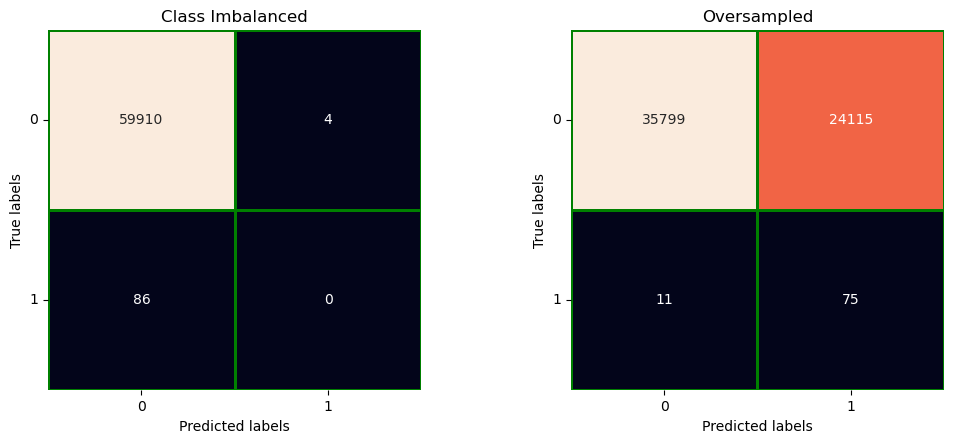

In [15]:
cm_heatmap_comparison(cart_hm,cart_hm_os,cart_model.classes_)

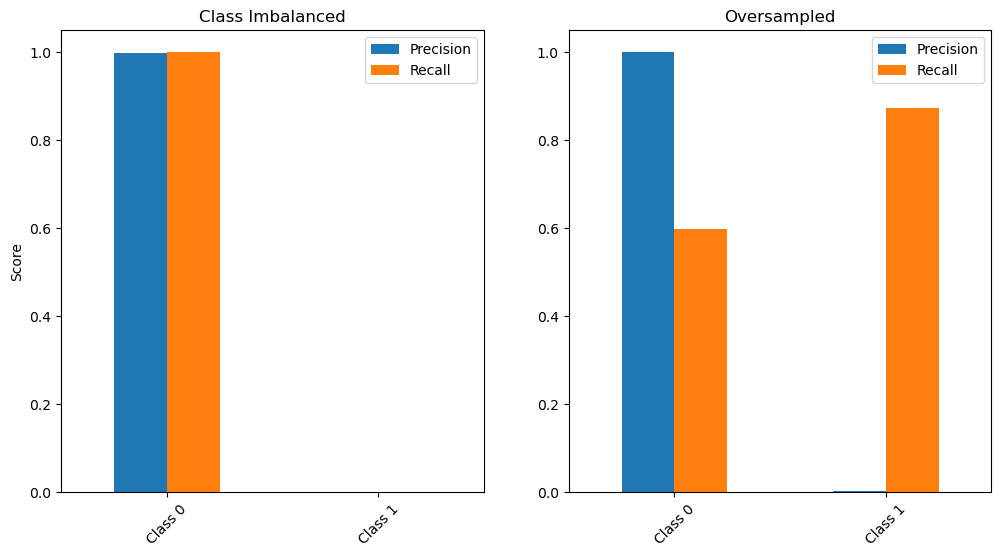

In [16]:
plot_classification_report_compare(cart_cr,cart_cr_os)

For the decistion tree model we see something similar. The model trained on the class imbalanced data set does poorly at identifying fradulent transactions. Then when we train it on the oversampled dataset, this causes it to perform better at identifying fradulent transactions at the expense of labeling many valid transactions as fradulent.

### Conclusion and Further Work

We saw in both  models that oversampling helped in terms of reducing false negatives but at the expense of producing higher false positives. While this would reduce losses for our financial systems, our customers would be upset that their valid transactions would be cancelled due to being falsely flagged as fradulent.

Oversampling is just one technique to address a class imbalanced dataset. But it has drawbacks as seen in the work above. In future works I would explore other techniques like implementing a loss function which would give greater weight to incorrectly labeling a fradulent transaction as valid. This I think would prevent overfitting. Further I would use grid search methods to tune the hyperparemeters of my models to achieve optimal performance. Finally I would even consider using ensemble methods like stacking to combine both logistical and decision tree models into one. 